Investigate the hits shown in the below plot with 0 and nonzero hits together. Theory: Those with low DR (like < 0.25Hz/s are seticore artifacts) and those with ~1Hz/s are wiggly signals

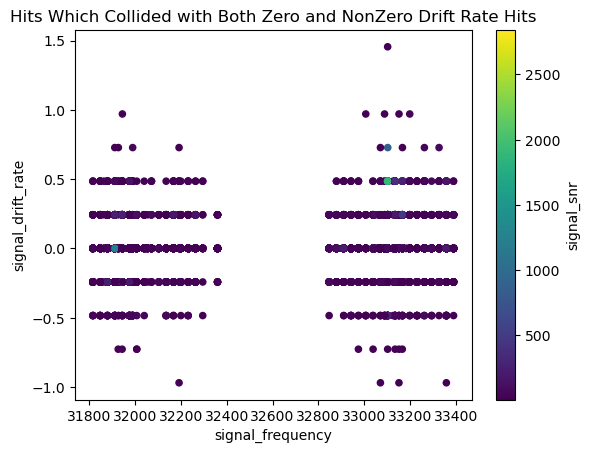

### Setup

In [1]:
# Import packages needed
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [2]:
# Load in the information of the hits we want to look at
df = pd.read_csv("/home/nstiegle/BL-COSMIC-2024-proj/frequency_adjacency/stamps_of_mixed_collision_groups/mixed_collision_groups.csv")
print(df.shape)

(11777, 17)


In [3]:
# Look for the stamp in a single stamp file
# Assumes the stamp_uri exists 
def find_stamp_in_single_file(stamp_uri, hit_frequency, threshold):
    # Check each stamp in the file to see if it matches
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for i, stamp in enumerate(stamps_gen):
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return i, stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None, None

# Given a stamp_uri, increments the index of the stamp file by one (so if it's /.../...seticore.0000.stamps it goes to /.../...seticore.0001.stamps)
def increment_stamp_uri(stamp_uri):
    split_uri = stamp_uri.split('.')
    assert(split_uri[-1] == 'stamps')
    num = int(split_uri[-2])
    num += 1
    split_uri[-2] = str(num).zfill(4)
    return ".".join(split_uri)

# Finds where the stamp of a given hit is
# Takes:
# - stamp URI (of stamp file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location_helper(stamp_uri, hit_frequency, threshold):
    # Check stamp file passed in exists
    if not os.path.exists(stamp_uri):
        return None, None
    
    # Look for stamp in the stamp file given
    index, stamp = find_stamp_in_single_file(stamp_uri, hit_frequency, threshold)
    if (index != None) and (stamp != None):
        return stamp_uri, index
    else:
        # Check if there's another stamp file (because stamps can get split up into multiple files)
        return find_stamp_location_helper(increment_stamp_uri(stamp_uri), hit_frequency, threshold)

# Finds where the stamp of a given hit is
# Takes:
# - hit URI (of .hits file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location(hit_uri, hit_frequency, threshold=500):
    # Convert a filepath from pointing to a .hits
    # to a .stamps file for the same uri
    # If given a .stamps ending, doesn't change it
    def stamp_filepath_of(hits_filepath):
        return hits_filepath.replace('.hits', '.0000.stamps')

    return find_stamp_location_helper(stamp_filepath_of(hit_uri), hit_frequency, threshold)

### Take subset of data

(10795, 17)


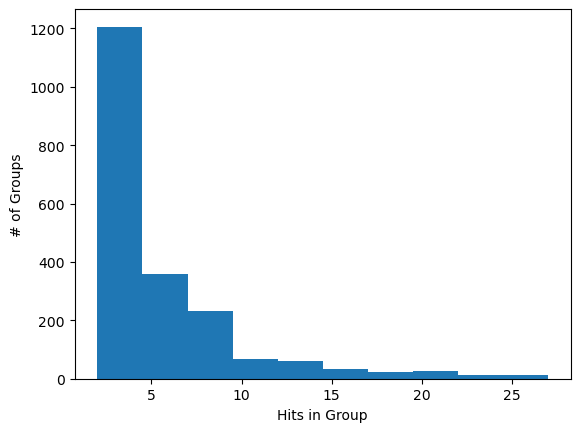

In [49]:
# Find all the collision groups which have a max drift rate < 0.25Hz
# First find indices of hits in those groups
groups = df.groupby("signal_frequency")
indices = np.array([], dtype=int)
for f, group in groups:
    if max(group.signal_drift_rate.values) < 0.25:
        indices = np.concatenate([indices, group.id.values.astype(int)])

# Then get a df with all those hits
df_index = df.set_index("id")
small_dr = df_index.loc[indices].reset_index()
print(small_dr.shape)

# Then group them back together
groups = [group for f, group in small_dr.groupby("signal_frequency")]
len(groups)

# Figure out how many elements each group has
group_sizes = [len(group) for group in groups]
plt.hist(group_sizes)
plt.xlabel("Hits in Group")
plt.ylabel("# of Groups")
plt.show()

# Let's look at the biggest group, one of the little groups, and two other random groups
max_group_index = group_sizes.index(max(group_sizes))
max_group = groups[max_group_index]

min_group_index = group_sizes.index(min(group_sizes))
min_group = groups[min_group_index]

misc_group_1 = groups[1320]
misc_group_2 = groups[735]

low_groups = [(max_group, "max_group"), (min_group, "min_group"), (misc_group_1, "misc_group_1"), (misc_group_2, "misc_group_2")]


(982, 17)


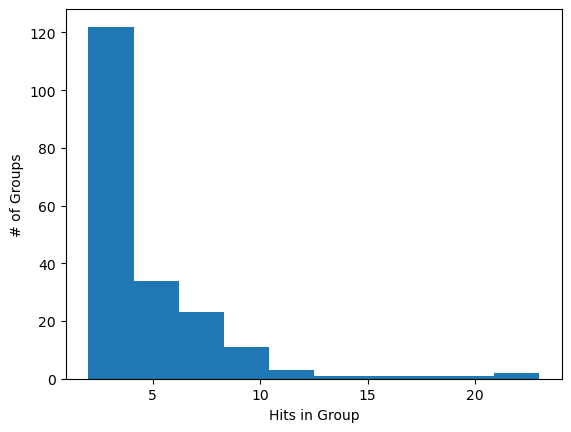

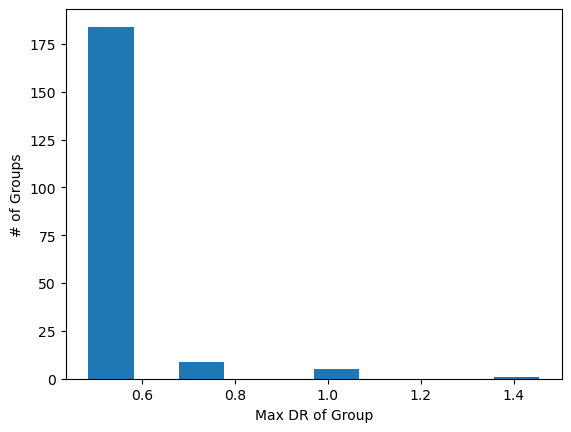

In [69]:
# Find all the collision groups which have a max drift rate between 0.25 and 2 Hz/s
# First find indices of hits in those groups
groups = df.groupby("signal_frequency")
indices = np.array([], dtype=int)
for f, group in groups:
    if max(group.signal_drift_rate.values) >= 0.25 and max(group.signal_drift_rate.values) < 2:
        indices = np.concatenate([indices, group.id.values.astype(int)])

# Then get a df with all those hits
df_index = df.set_index("id")
small_dr = df_index.loc[indices].reset_index()
print(small_dr.shape)

# Then group them back together
groups = [group for f, group in small_dr.groupby("signal_frequency")]
len(groups)

# Figure out how many elements each group has
group_sizes = [len(group) for group in groups]
plt.hist(group_sizes)
plt.xlabel("Hits in Group")
plt.ylabel("# of Groups")
plt.show()

group_max_drs = [group.signal_drift_rate.max() for group in groups]
plt.hist(group_max_drs)
plt.xlabel("Max DR of Group")
plt.ylabel("# of Groups")
plt.show()

# # Let's look at the biggest group, one of the little groups, and two other random groups. Also group with highest dr
high_max_group_index = group_sizes.index(max(group_sizes))
high_max_group = groups[high_max_group_index]

high_min_group_index = group_sizes.index(min(group_sizes))
high_min_group = groups[high_min_group_index]

high_highest_group_index = group_max_drs.index(max(group_max_drs))
high_highest_group = groups[high_highest_group_index]

np.random.seed(1)
high_misc_group_1 = groups[np.random.randint(0, high=len(groups))]
high_misc_group_2 = groups[np.random.randint(0, high=len(groups))]

high_groups = [(max_group, "high_max_group"), (min_group, "high_min_group"), (misc_group_1, "high_misc_group_1"), (misc_group_2, "high_misc_group_2"), (high_highest_group, "high_highest_group")]


### Look at stamps

In [62]:
for group, name in low_groups:
    group.reset_index(inplace=True, drop=True)
    
    # Find all the stamps in the group
    stamp_uris = []
    indices_in_stamps = []
    for i, row in group.iterrows():
        stamp_uri, index_in_stamp = find_stamp_location(row.file_uri, row.signal_frequency)
        stamp_uris.append(stamp_uri)
        indices_in_stamps.append(index_in_stamp)

    group["stamp_uri"] = stamp_uris
    group["stamp_index"] = indices_in_stamps

    # Setup to save stamps
    dir_path = "/home/nstiegle/BL-COSMIC-2024-proj/frequency_adjacency/stamps_of_mixed_collision_groups/"
    # Make folder for these stamps if there isn't one
    folder_path = dir_path + name
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    # Save the stamps of them
    for i in range(len(group)):
        stamps = [stamp for stamp in viewer.read_stamps(group["stamp_uri"][i], find_recipe=True)]
        stamp = stamps[group["stamp_index"][i]]
        assert(stamp != None)
        assert(stamp.recipe != None)
        stamp.show_antennas(show_signal=True, title=f"Stamp {i}", save_to=f"{folder_path}/stamp_{i}.png")
        # stamp.show_best_beam(show_signal=True, title=f"Stamp {i} best beam", save_to=f"{folder_path}/stamp_{i}_best_beam.png")
        stamp.show_classic_incoherent(show_signal=True, title=f"Stamp {i} incoherent", save_to=f"{folder_path}/stamp_{i}_incoherent.png") 

recalculated power: 6.283967e+11
local SNR: 113.73659729180822
recalculated power: 6.034429e+11
local SNR: 107.3150410301288
recalculated power: 6.003601e+11
local SNR: 110.47570866855301
recalculated power: 5.684378e+11
local SNR: 96.36357493478573
recalculated power: 5.759905e+11
local SNR: 85.23880233420236
recalculated power: 5.831118e+11
local SNR: 90.51462543438245
recalculated power: 5.901048e+11
local SNR: 88.29531232557282
recalculated power: 5.709245e+11
local SNR: 84.75651776780683
recalculated power: 5.830151e+11
local SNR: 123.64254220137954
recalculated power: 5.691542e+11
local SNR: 98.87078029096278
recalculated power: 6.129785e+11
local SNR: 112.21945426847441
recalculated power: 5.933620e+11
local SNR: 105.22704172355736
recalculated power: 5.775087e+11
local SNR: 96.9799527939011
recalculated power: 5.833527e+11
local SNR: 101.54823820045007
recalculated power: 5.858116e+11
local SNR: 103.69883905362417
recalculated power: 5.601290e+11
local SNR: 110.04405898936218
r

In [70]:
for group, name in high_groups:
    group.reset_index(inplace=True, drop=True)
    
    # Find all the stamps in the group
    stamp_uris = []
    indices_in_stamps = []
    for i, row in group.iterrows():
        stamp_uri, index_in_stamp = find_stamp_location(row.file_uri, row.signal_frequency)
        stamp_uris.append(stamp_uri)
        indices_in_stamps.append(index_in_stamp)

    group["stamp_uri"] = stamp_uris
    group["stamp_index"] = indices_in_stamps

    # Setup to save stamps
    dir_path = "/home/nstiegle/BL-COSMIC-2024-proj/frequency_adjacency/stamps_of_mixed_collision_groups/"
    # Make folder for these stamps if there isn't one
    folder_path = dir_path + name
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    # Save the stamps of them
    for i in range(len(group)):
        stamps = [stamp for stamp in viewer.read_stamps(group["stamp_uri"][i], find_recipe=True)]
        stamp = stamps[group["stamp_index"][i]]
        assert(stamp != None)
        assert(stamp.recipe != None)
        stamp.show_antennas(show_signal=True, title=f"Stamp {i}", save_to=f"{folder_path}/stamp_{i}.png")
        # stamp.show_best_beam(show_signal=True, title=f"Stamp {i} best beam", save_to=f"{folder_path}/stamp_{i}_best_beam.png")
        stamp.show_classic_incoherent(show_signal=True, title=f"Stamp {i} incoherent", save_to=f"{folder_path}/stamp_{i}_incoherent.png") 

recalculated power: 6.283967e+11
local SNR: 113.73659729180822
recalculated power: 6.034429e+11
local SNR: 107.3150410301288
recalculated power: 6.003601e+11
local SNR: 110.47570866855301
recalculated power: 5.684378e+11
local SNR: 96.36357493478573
recalculated power: 5.759905e+11
local SNR: 85.23880233420236
recalculated power: 5.831118e+11
local SNR: 90.51462543438245
recalculated power: 5.901048e+11
local SNR: 88.29531232557282
recalculated power: 5.709245e+11
local SNR: 84.75651776780683
recalculated power: 5.830151e+11
local SNR: 123.64254220137954
recalculated power: 5.691542e+11
local SNR: 98.87078029096278
recalculated power: 6.129785e+11
local SNR: 112.21945426847441
recalculated power: 5.933620e+11
local SNR: 105.22704172355736
recalculated power: 5.775087e+11
local SNR: 96.9799527939011
recalculated power: 5.833527e+11
local SNR: 101.54823820045007
recalculated power: 5.858116e+11
local SNR: 103.69883905362417
recalculated power: 5.601290e+11
local SNR: 110.04405898936218
r